## Studying Growth Instability

This code lets us explore how QLC-2 solutions vary with the following parameters:
- $\overline N$, and $N^*$ (atomistic-level characteristics of the ice QLL thicknesses)
- $\sigma_o$ (difference in equilibrium supersaturation between microsurfaces I and II)
- $h_{pr}$ (thickness of a prismatic facet monolayer)
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (kinetic velocity -- the rate at which water vapor strikes the surface)
- $L$ (physical length of the facet surface)
- $nx_{crystal}$ (number of discrete points used to represent the surface)
- $L$ (crystal dimension)
- $\sigma_{I,corner}$ (imposed supersaturation at the facet corner)
- $c_r$ (relative reduction in supersaturation at facet centers relative to corners, in fraction and %)
- $\tau_{eq}$ (time constant for ice/QLL freezing/thawing)

In addition, there's the possibility of activating the "microsurface" capablity, by specifying microsurfaces=1. In that case, additional parameters are needed:
- $\sigma_0$ multiplier (how the volatility of the pyramidal facet compares to that of the prismatic (>1 => less volatile)
- $h_{py}$ multiplier (how the thickness of a pyramidal compares to that of the prismatic (>1 => thicker)
- $N^*$ multiplier (how the variability of the pyramidal facet compares to that of the prismatic (>1 => more variable)
- $\theta$ (angle of the additional microfacet with respect to the prismatic (for pyramidal, this is 28 degrees)
- $\beta_{trans}$ multiplier (gradualness of transition between microfacet angles (smaller => more gradual))

These are specified as small departures from a baseline scenario, taken from *Parameter Baseline*, which tries to come up with a self-consistent set of parameters at given values of:
- $T$ (ambient temperature)
- $P$ (ambient air pressure)
- $\sigma_{I,far}$ and $x_{far}$ (super/subsaturation of water vapor far from the crystal, and distance from the crystal at which $\sigma_{I,far}$ is specified)

In [1]:
import numpy as np
import matplotlib.pylab as plt
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from importlib import reload
from scipy import optimize
from matplotlib import rcParams
from scipy.fft import fft, ifft, rfft, irfft, fftfreq

import sys
sys.path.append('..')
import QLCstuff as QLC

In [2]:
%matplotlib notebook
ticklabelsize = 15
linewidth = 1
fontsize = 15
titlefontsize = 8
color = 'k'
markersize = 10

# Preferred units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
temperature_unit = 'kelvin'

### Defining default parameters for runs

In [3]:
# Properties of the QLL
Nbar = 1.0
print('Nbar', Nbar)
Nstar = 0.1
print('Nstar', Nstar)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = 0.2
print('sigma0 =',sigma0)

# Thickness of monolayers
h_pr = AssignQuantity(0.389,'nanometer') # Prismatic facet as used in Neshyba et al 2016
print('h_pr', h_pr)
h_pr.ito('micrometer')

# Diffusion coeficient
D = AssignQuantity(3.65e-04,'micrometer^2/microsecond')
print('D',D)

# Kinetic velocity
nu_kin = AssignQuantity(140,'micrometer/second')
print('nu_kin', nu_kin)

# Size of the facet
L = AssignQuantity(30,'micrometer')
print('L', L)

# Crystal size -- needs to be an even number
nx_crystal = 320 
print('nx (crystal)', nx_crystal)

# Supersaturation at the corner of a facet
sigmaI_corner = AssignQuantity(0.22,'dimensionless') 
print('sigmaI_corner', sigmaI_corner)

# Reduction of supersaturation at the facet cental
c_r_percent = AssignQuantity(1.068,'dimensionless')
print('c_r_percent',c_r_percent)

# Time constant for freezing/thawing
tau_eq = AssignQuantity(5.0,'microsecond')
tau_eq = AssignQuantity(10.0,'microsecond')
print('tau_eq',tau_eq)

# Integration algorithm (other possibilities: RK23, DOP853, LSODA, and Radau)
odemethod = 'RK45' # Explicit Runge-Kutta
# odemethod = 'BDF' # Implicit multi-step variable-order (1 to 5) method (takes ~100x explicit methods)

Nbar 1.0
Nstar 0.1
sigma0 = 0.2
h_pr 0.389 nanometer
D 0.000365 micrometer ** 2 / microsecond
nu_kin 140 micrometer / second
L 30 micrometer
nx (crystal) 320
sigmaI_corner 0.22 dimensionless
c_r_percent 1.068 dimensionless
tau_eq 10.0 microsecond


### Below are microfacet parameters (ignored if microfacets=0)

In [4]:
# Whether to use microfacets (0 => no microfaceting)
microfacets = 1
print('microfacets',microfacets)

# How the volatility of the pyramidal facet compares to that of the prismatic (>1 => less volatile)
sigma0factor = 1.1
print('sigma0factor',sigma0factor)

# How the pyramidal layer thickness compares to the prismatic (>1 => thicker)
h_pyfactor = 1 
print('h_pyfactor',h_pyfactor)

# How the variability of the pyramidal facet compares to that of the prismatic (>1 => more variable)
Nstarfactor = 0.7
print('Nstarfactor',Nstarfactor)

# Angle of the pyramidal facet
theta = AssignQuantity(20, 'degrees')
print('theta',theta)

# Gradualness of transition between prismatic and pyramidal angles (smaller => more gradual)
beta_trans_factor = 4
print('beta_trans_factor',beta_trans_factor)

microfacets 1
sigma0factor 1.1
h_pyfactor 1
Nstarfactor 0.7
theta 20 degree
beta_trans_factor 4


### Varibles that depend on the above

In [5]:
c_r = c_r_percent/100
x_QLC = np.linspace(-L,L,nx_crystal)
sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)
nu_kin_mlyperus = nu_kin/h_pr
nu_kin_mlyperus.ito('1/microsecond')
deltax = x_QLC[1]-x_QLC[0]
print('Spacing of points on the ice surface =', deltax)
Doverdeltax2 = D/deltax**2

Spacing of points on the ice surface = 0.18808777429467227 micrometer


### Run the scenario

In [20]:
tlast = AssignQuantity(10000,'millisecond') # Use this line to override the estimated time
tlast.ito('microsecond')

# Number of time steps to keep for reporting later
ntimes = 100

fresh_run = False # If False, we're padding on to a previous execution of this cell
if fresh_run:
    tkeep_1Darr = np.linspace(0,tlast,ntimes)
    Ntot_init_1D = np.ones(nx_crystal)
    NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)
else:
    tstart = tkeep_1Darr[-1]
    tstop = tstart + tlast
    tkeep_1Darr = np.linspace(tstart,tstop,ntimes)
    Ntot_init_1D = Ntotkeep_1D[-1,:]
    NQLL_init_1D = NQLLkeep_1D[-1,:]

print('This is a run from time', tkeep_1Darr[0].to('msec'),'to', tkeep_1Darr[-1].to('msec'))
print('dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

# Label for graphs
title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        "\n"+\
        "{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        "\n"+\
        "{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.1f}".format(tau_eq.magnitude)+' '+str(tau_eq.units)+\
        ", "+"{:.3f}".format(c_r_percent.magnitude)+'%'+\
        ", "+odemethod+\
        "\n"
    
# Solve the 1-D problem
Ntotkeep_1D, NQLLkeep_1D = QLC.run_pypr(\
                    NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
                    Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, \
                    theta, beta_trans_factor, Nstarfactor, h_pr, h_pyfactor, sigma0factor,\
                    sigmaI_QLC, x_QLC,
                    AssignQuantity,\
                    verbose=0, odemethod=odemethod, microfacets=microfacets)
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

This is a run from time 10000.0 millisecond to 20000.0 millisecond
dt = 101010.10101010092 microsecond
Shape of the smooth list is  (2,)
Shape of the smooth list is  (1,)
Shape of the smooth list is  (2,)
Shape of the smooth list is  (1,)
Shape of the smooth list is  (2,)
Shape of the smooth list is  (1,)
Shape of the smooth list is  (2,)
Shape of the smooth list is  (1,)
Shape of the smooth list is  (2,)
Shape of the smooth list is  (1,)
Shape of the smooth list is  (2,)
10 % elapsed time is 1.797 minutes
Shape of the smooth list is  (1,)
Shape of the smooth list is  (2,)
Shape of the smooth list is  (1,)
Shape of the smooth list is  (2,)
Shape of the smooth list is  (1,)
Shape of the smooth list is  (2,)
Shape of the smooth list is  (1,)
Shape of the smooth list is  (2,)
Shape of the smooth list is  (1,)
Shape of the smooth list is  (2,)
20 % elapsed time is 3.312 minutes
Shape of the smooth list is  (1,)
Shape of the smooth list is  (2,)
Shape of the smooth list is  (1,)
Shape of th

In [21]:
# tmp = np.array([[[]]])
# print(tmp)
# print(tmp.shape)
# print(len(tmp))
# print()
# tmp = np.squeeze(tmp)
# print(tmp)
# print(tmp.shape)
# print(len(tmp))

In [22]:
# tmp = np.array([1,2,2])
# itmplist = np.argwhere(tmp==2)
# print(itmplist)
# itmplist = itmplist.reshape(-1)
# #print(itmplist)
# for itmp in itmplist:
#     print(itmp, type(itmp))
#     print(tmp[itmp])
#     print(tmp[itmp-1:itmp+1])

<IPython.core.display.Javascript object>


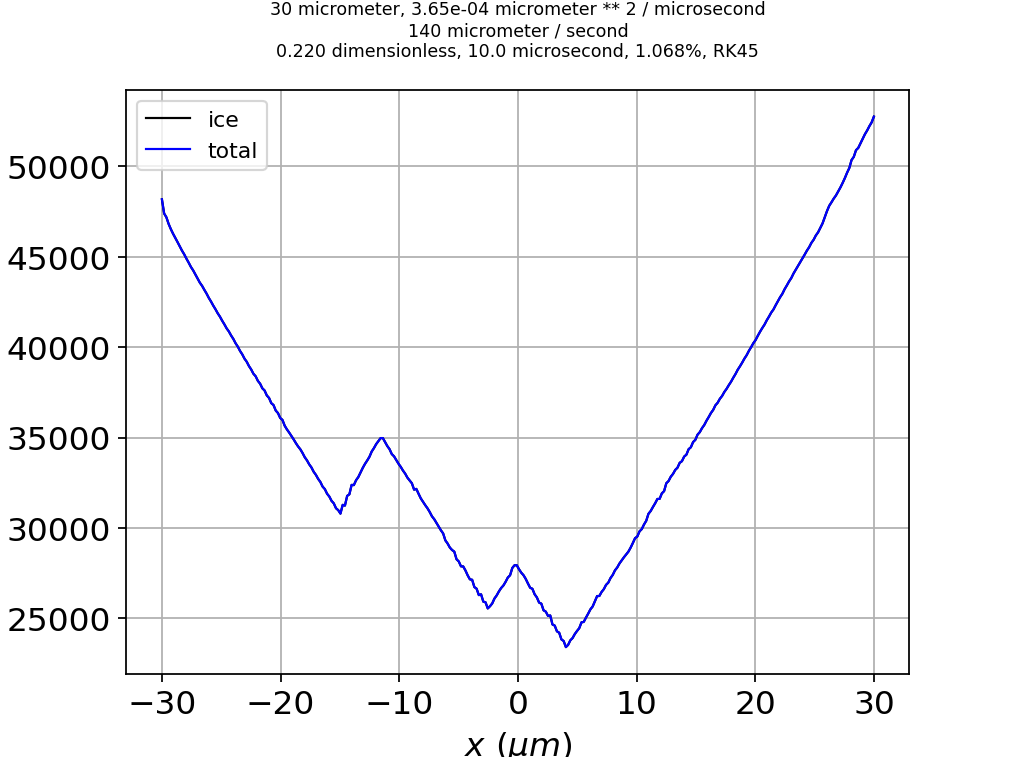

<IPython.core.display.Javascript object>


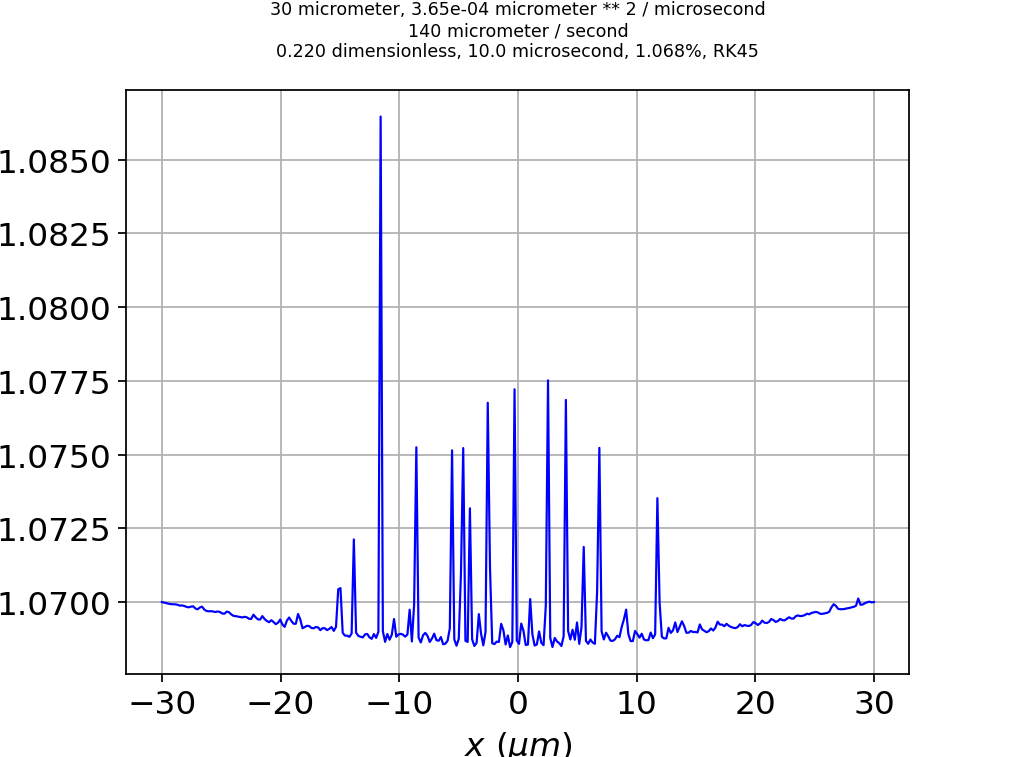

<IPython.core.display.Javascript object>


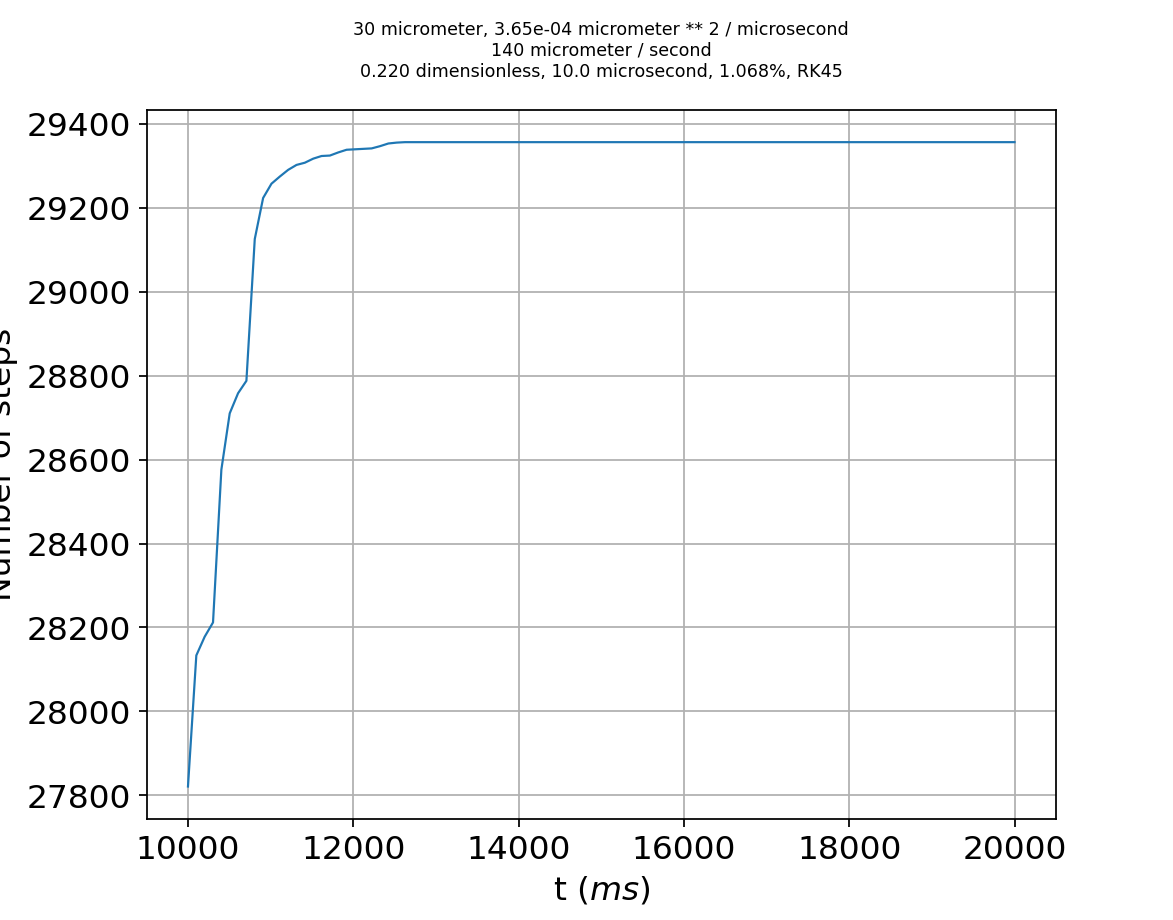

alpha_sticking relative to sigmaI_corner = -2.0034363896332533e-12 dimensionless


<IPython.core.display.Javascript object>


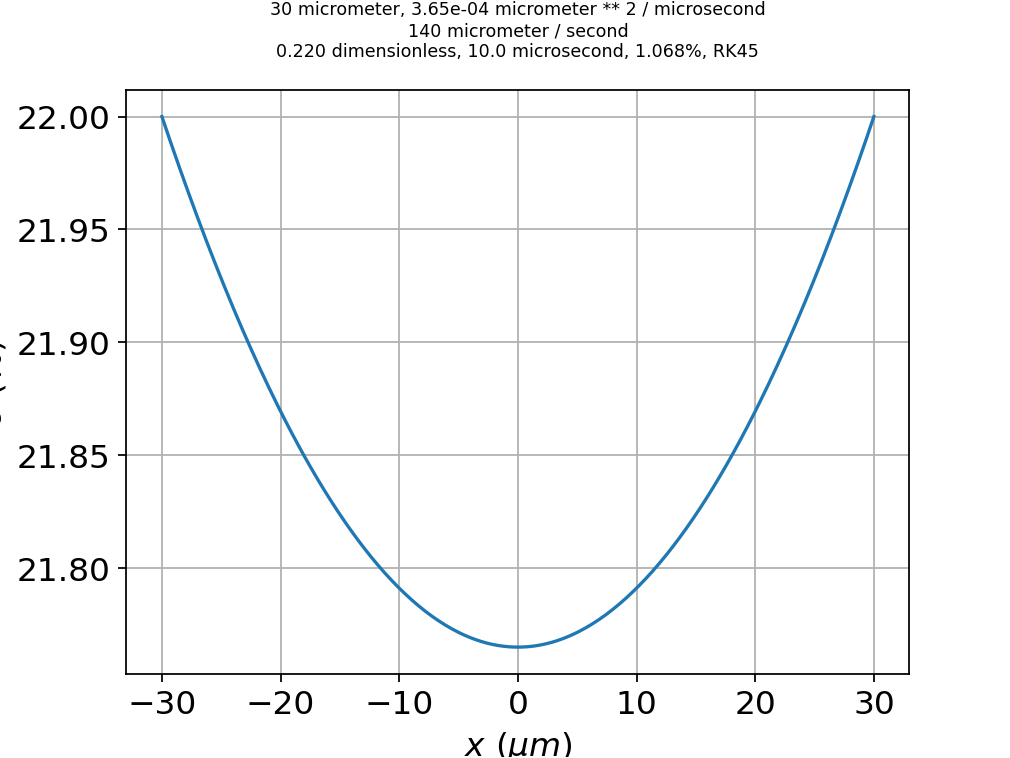

<IPython.core.display.Javascript object>


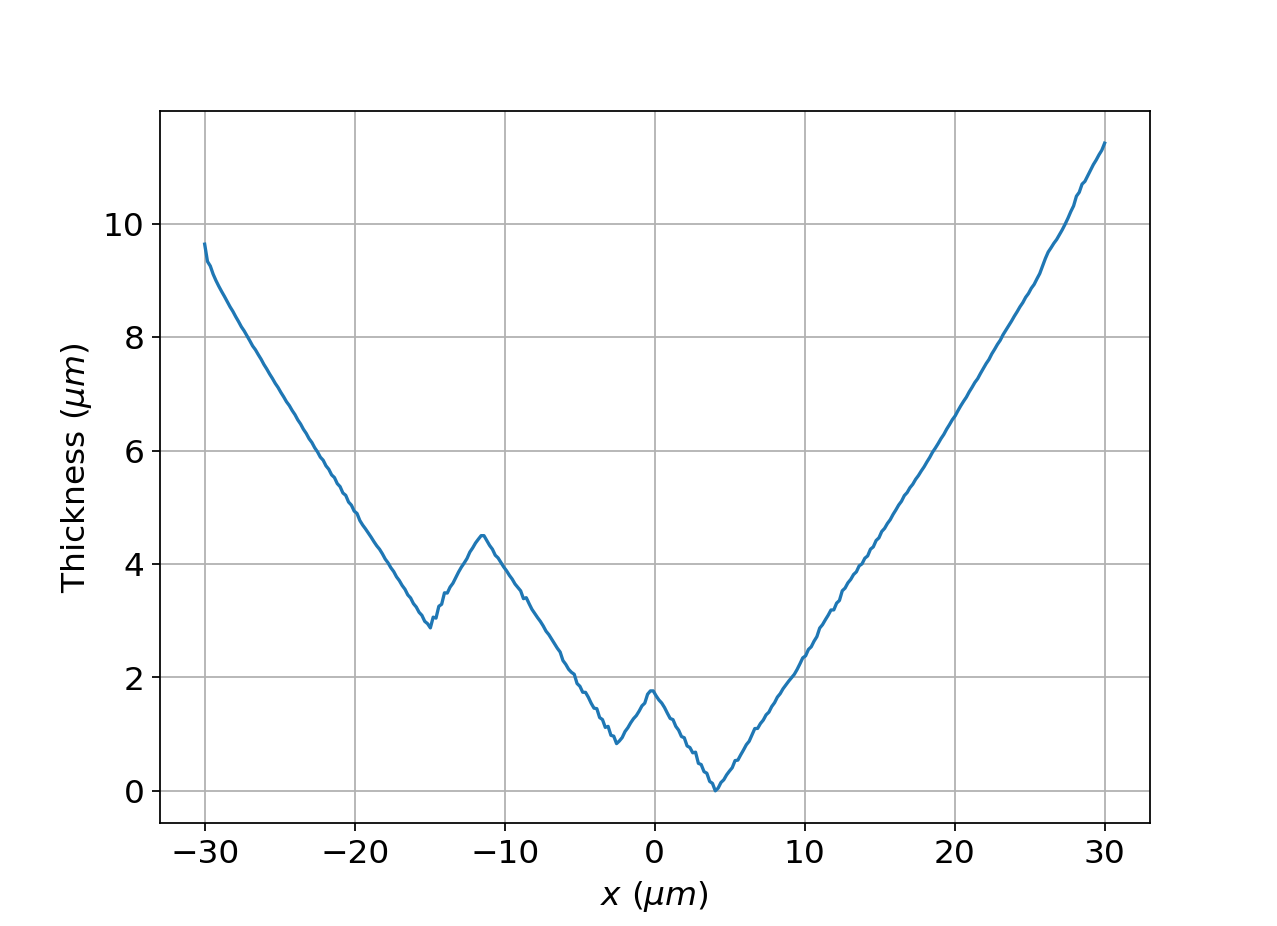

/var/folders/d4/79k8920n66j07rbcltjlhjx00000gr/T/ipykernel_40067/1443474725.py:31: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<IPython.core.display.Javascript object>


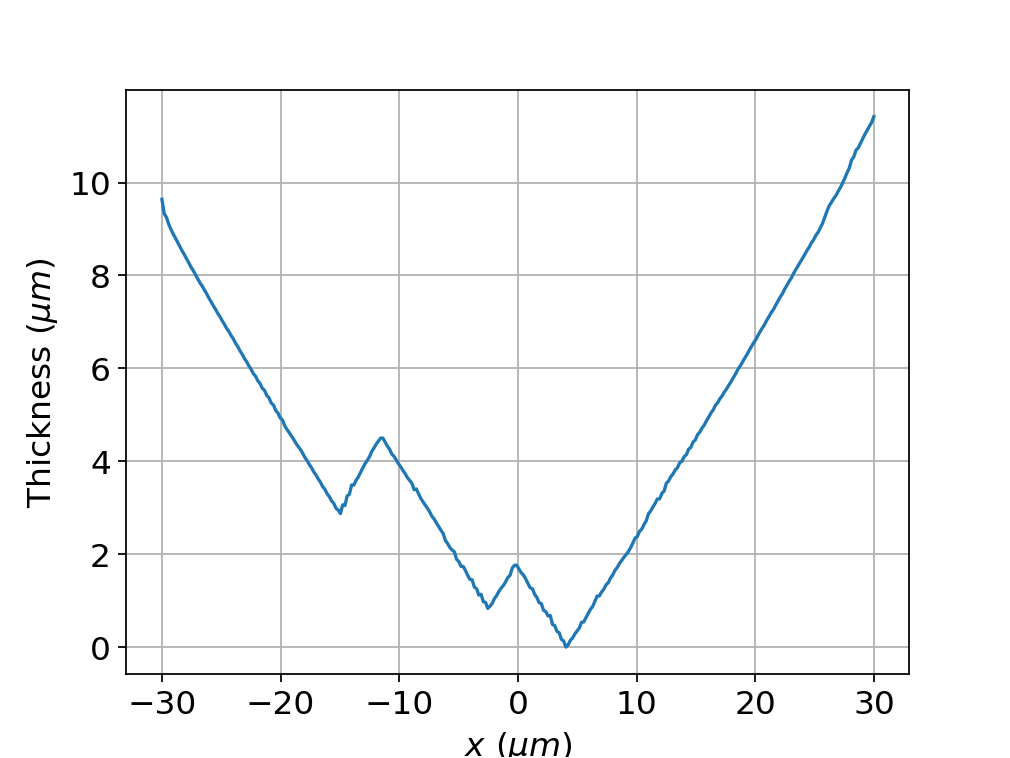

Text(0, 0.5, 'Thickness ($\\mu m)$')

In [23]:
# Reporting and graphing
g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,title_params=title_params)

# This is only of interest if we're looking at the "sticking" coefficient
alpha_sticking = g_ice_QLC/(sigmaI_corner*nu_kin)
alpha_sticking = AssignQuantity(alpha_sticking,'dimensionless')
print('alpha_sticking relative to sigmaI_corner =',alpha_sticking)

# Additional graphing
plt.figure()
plt.plot(x_QLC.magnitude,sigmaI_QLC.magnitude*100)
plt.grid(True)
plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
plt.ylabel('$\sigma \ (\%)$',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.title(title_params,fontsize=titlefontsize)

# Ntot in micrometers (instead of layers)
plt.figure()
ydiff = Ntotkeep_1D[-1,:]*h_pr
ydiff = ydiff - np.min(ydiff)
plt.plot(x_QLC.magnitude,ydiff.magnitude)
plt.grid(True)
plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
plt.ylabel('Thickness ($\mu m)$',fontsize=fontsize)

# # Check out symmetry
# itime = -1
# thisNQLL = NQLLkeep_1D[itime,:]
# thisNQLL_flipped = np.flip(thisNQLL)
# plt.figure()
# plt.plot(x_QLC.magnitude,(thisNQLL_flipped-thisNQLL))
# plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
# plt.grid(True)
# plt.title('QLL symmetry check',fontsize=titlefontsize)

<IPython.core.display.Javascript object>


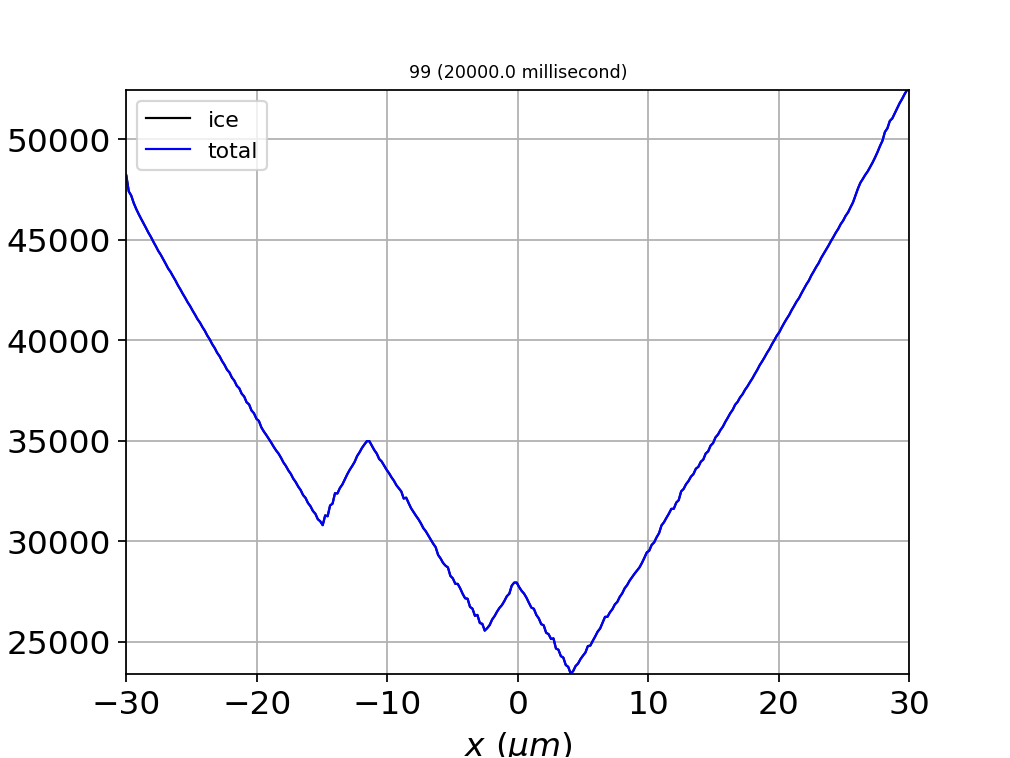

<IPython.core.display.Javascript object>


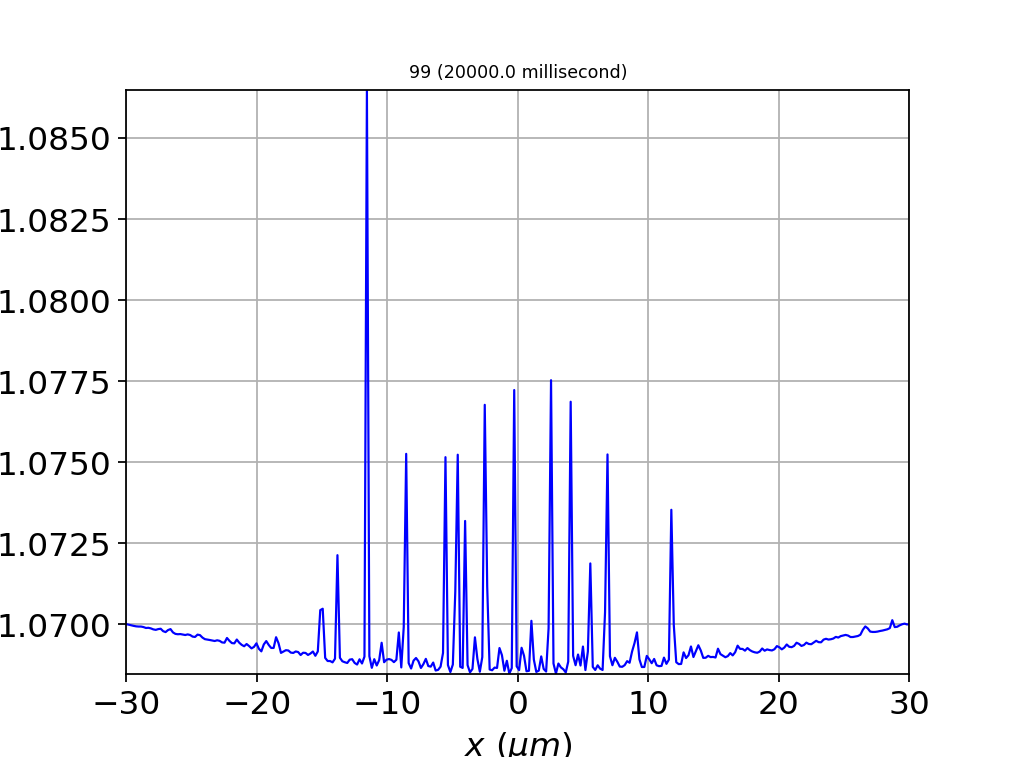

<IPython.core.display.Javascript object>


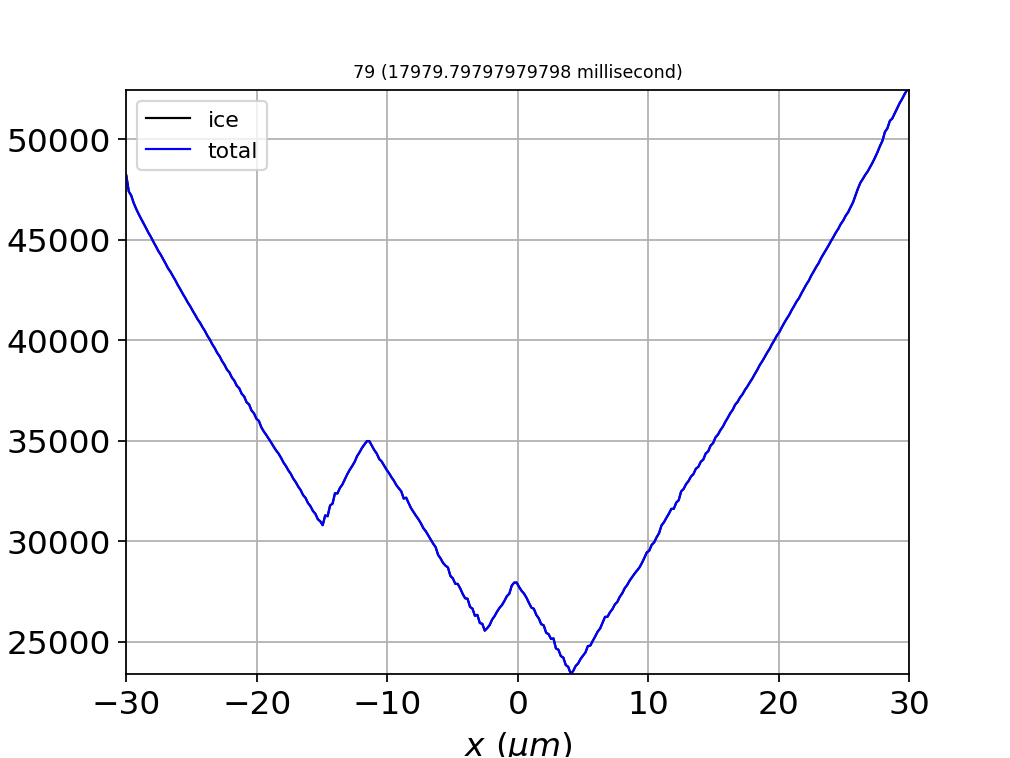

<IPython.core.display.Javascript object>


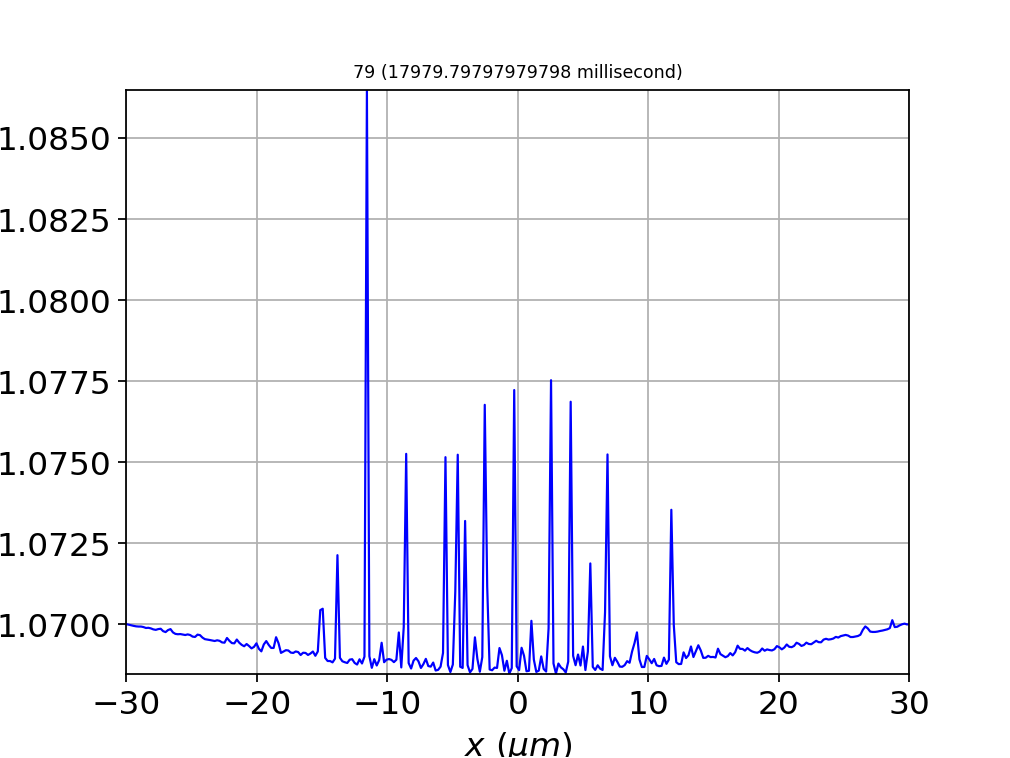

<IPython.core.display.Javascript object>


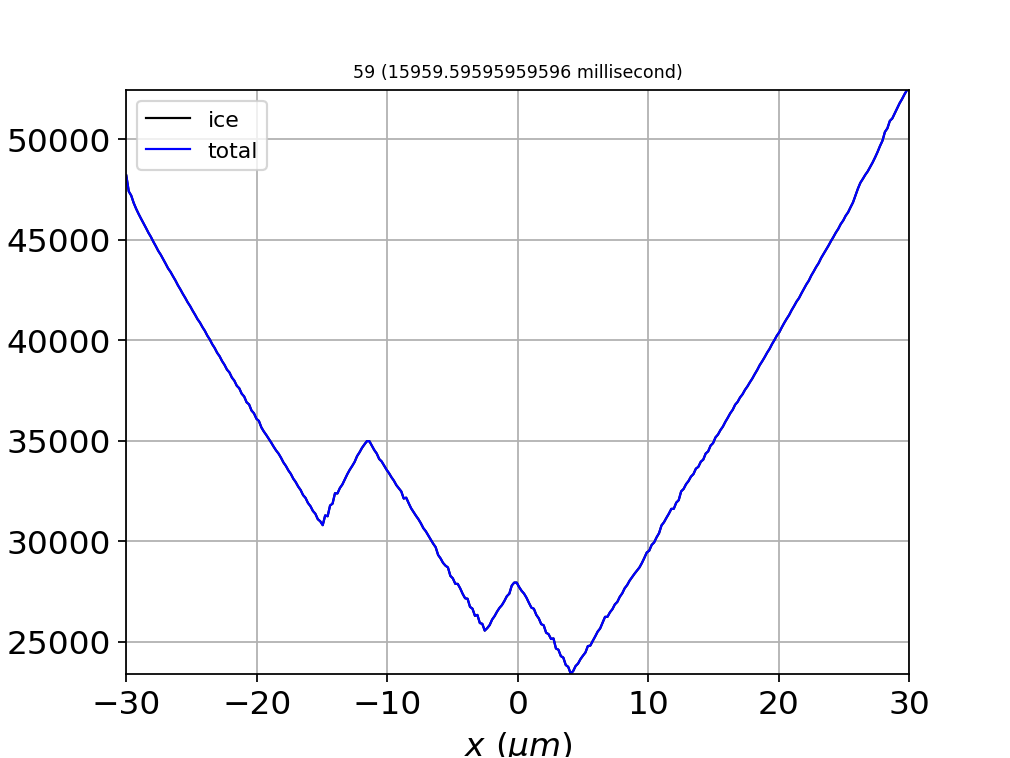

<IPython.core.display.Javascript object>


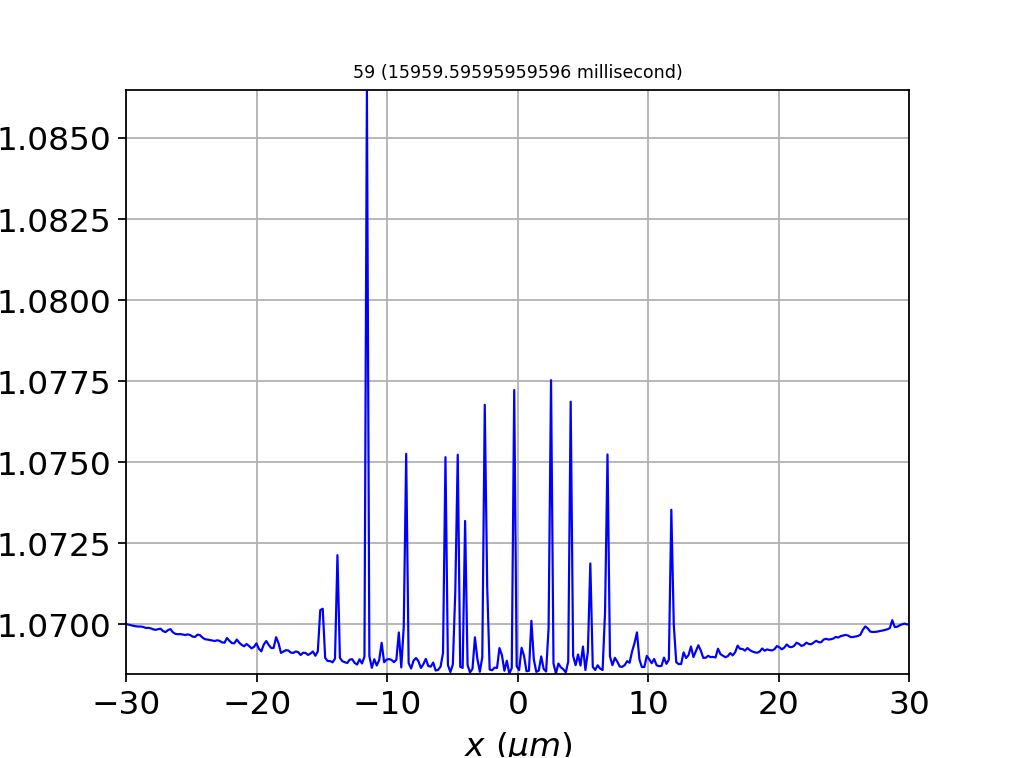

<IPython.core.display.Javascript object>


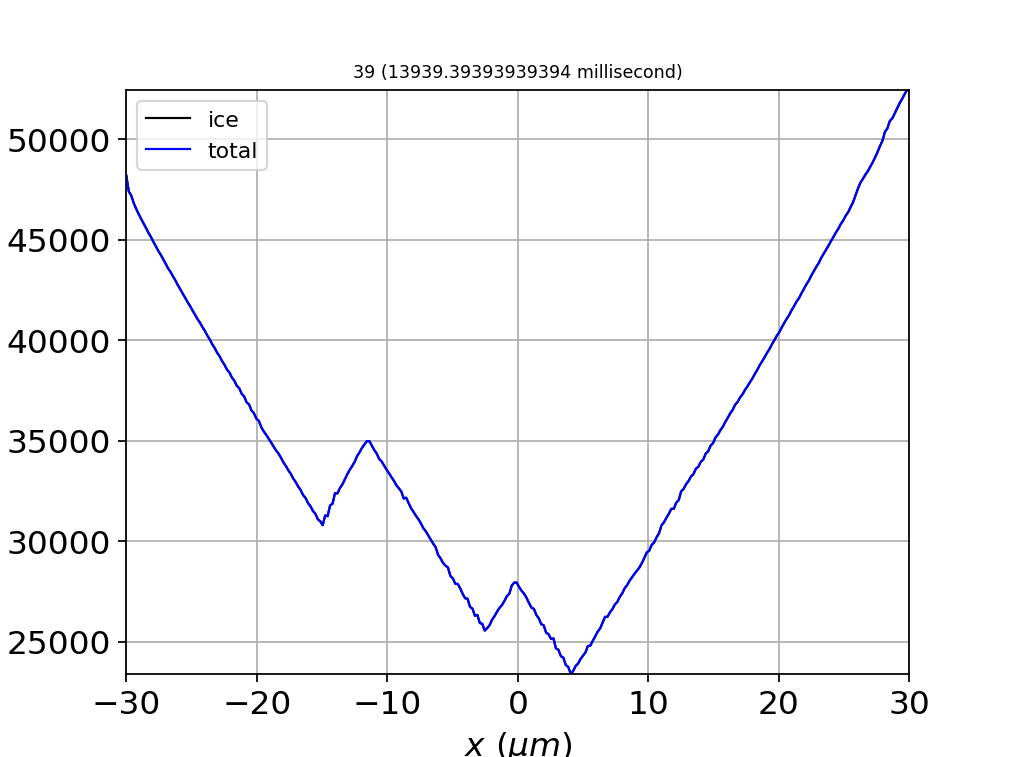

<IPython.core.display.Javascript object>


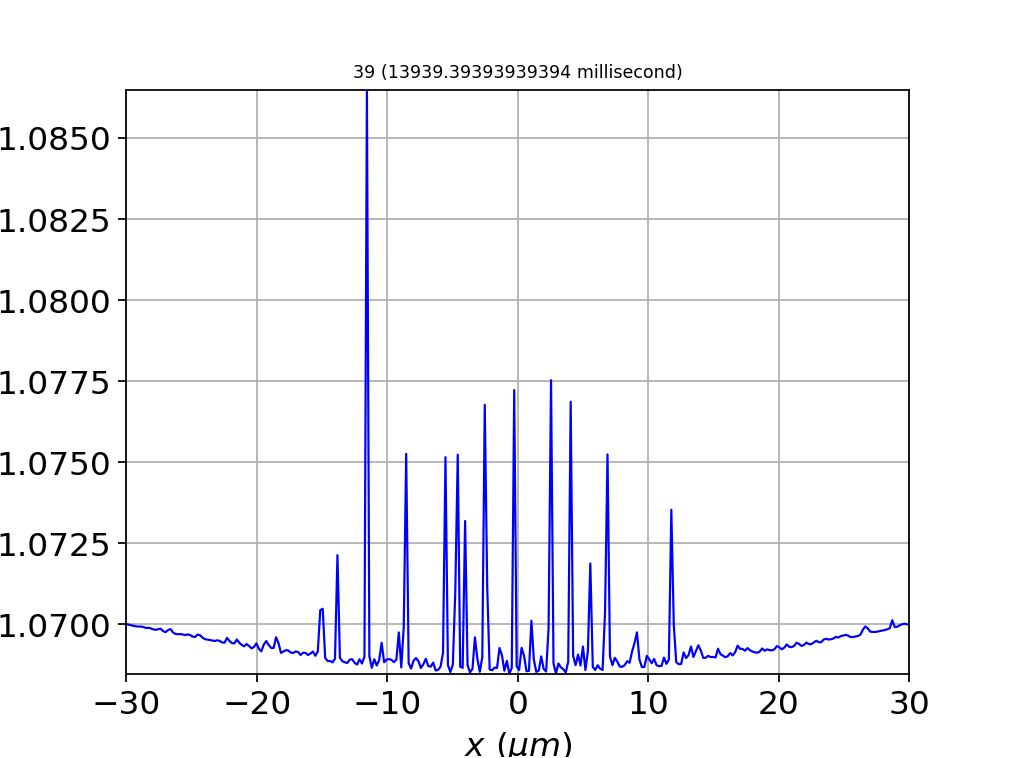

<IPython.core.display.Javascript object>


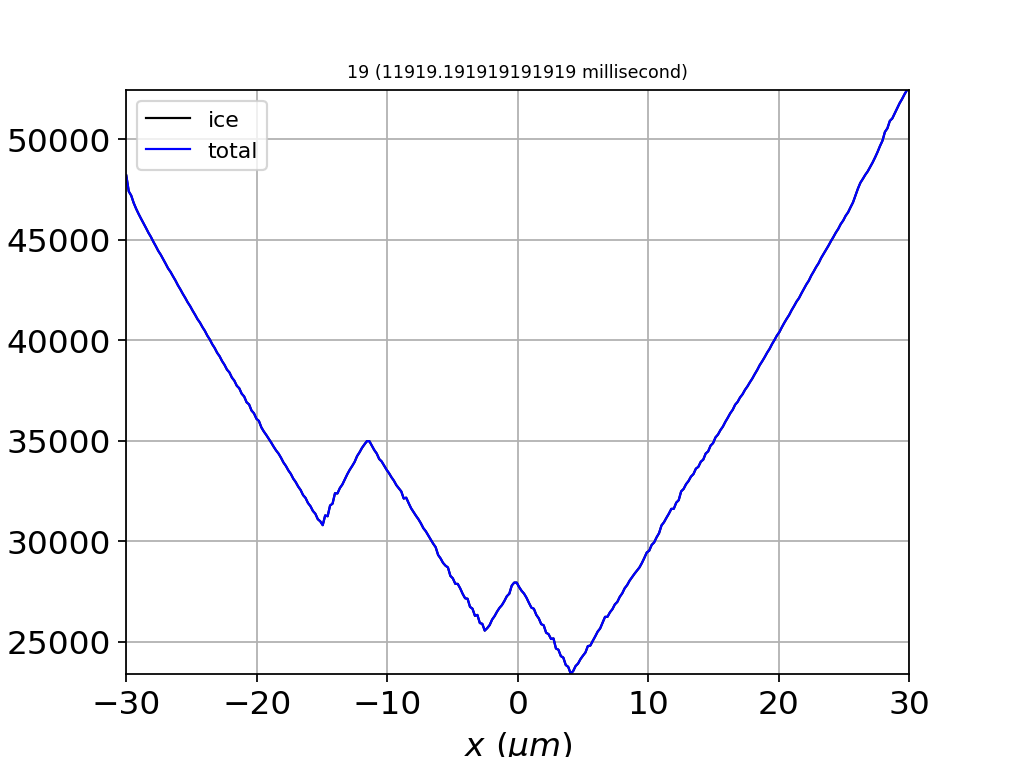

/Users/nesh/Documents/Repositories/icecontinuum/2024 - Filippo/../QLCstuff.py:504: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<IPython.core.display.Javascript object>


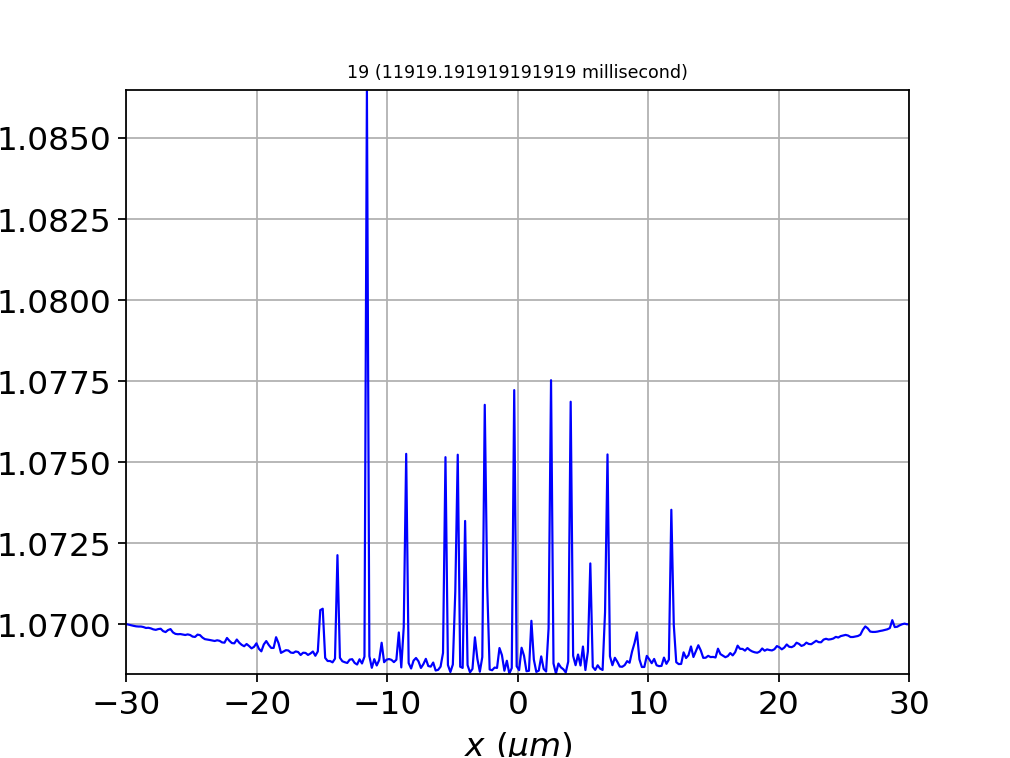

In [24]:
# Check out intermediate values
for itime in range(ntimes-1,0,-20):
    title_params = str(itime)+' ('+str(tkeep_1Darr[itime].to('millisecond'))+')'
    g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,h_pr, \
        graphics=True,tgraphics=False,title_params=title_params,itime=itime, \
        xlim=[-30,30])

Probing itime = -1
Probing time = 20000.0 millisecond
beta_trans = 0.17632698070846498 dimensionless
delta_beta 0.044081745177116244 dimensionless


<IPython.core.display.Javascript object>


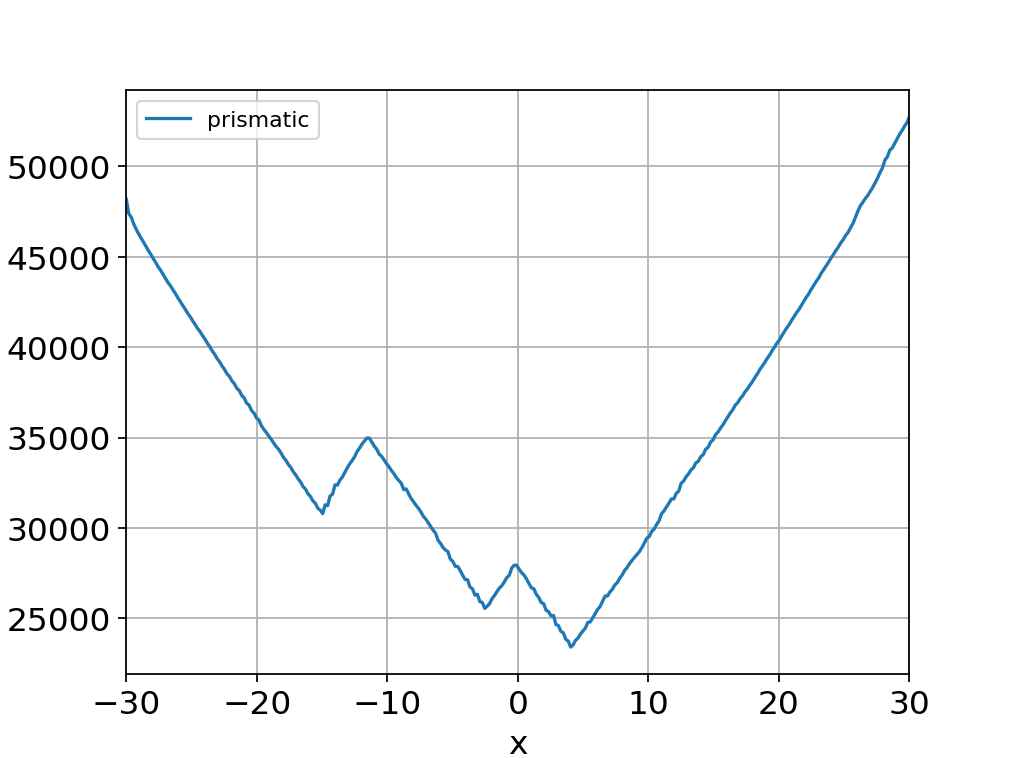

<IPython.core.display.Javascript object>


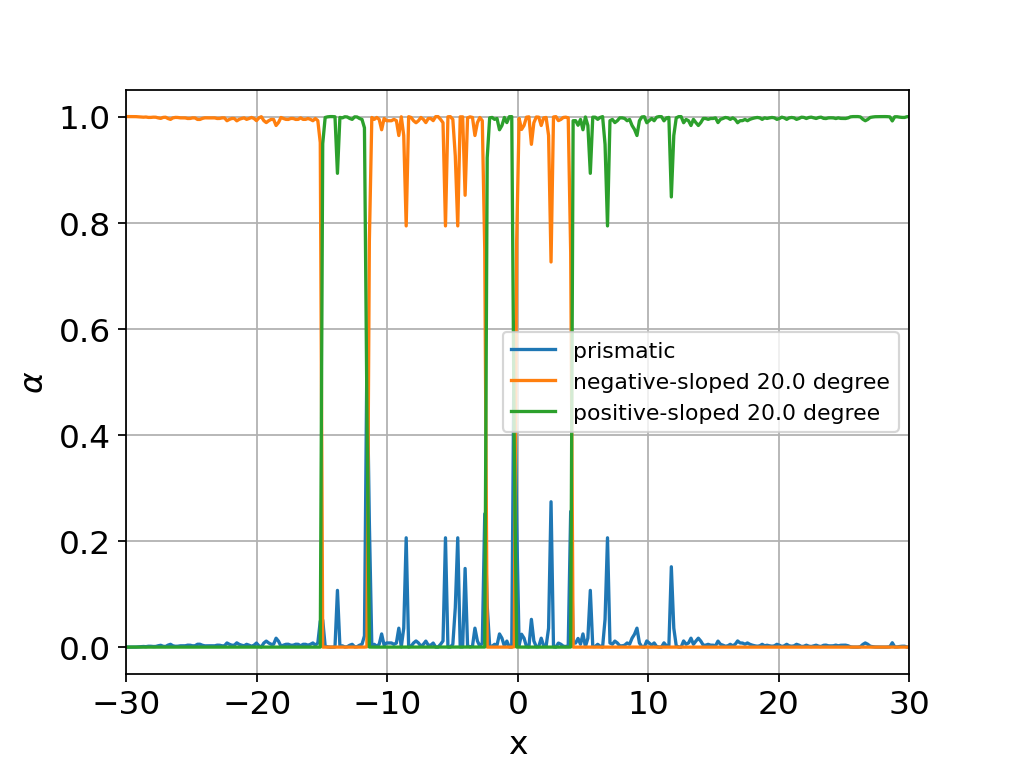

0.06999999999999999


<IPython.core.display.Javascript object>


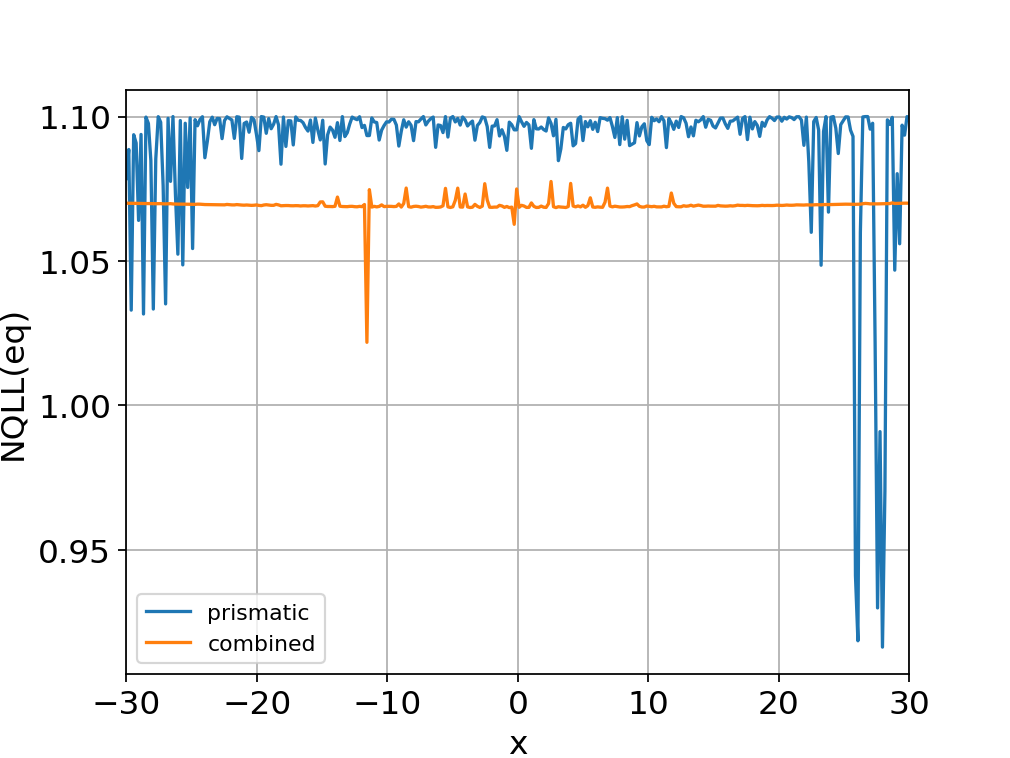

<IPython.core.display.Javascript object>


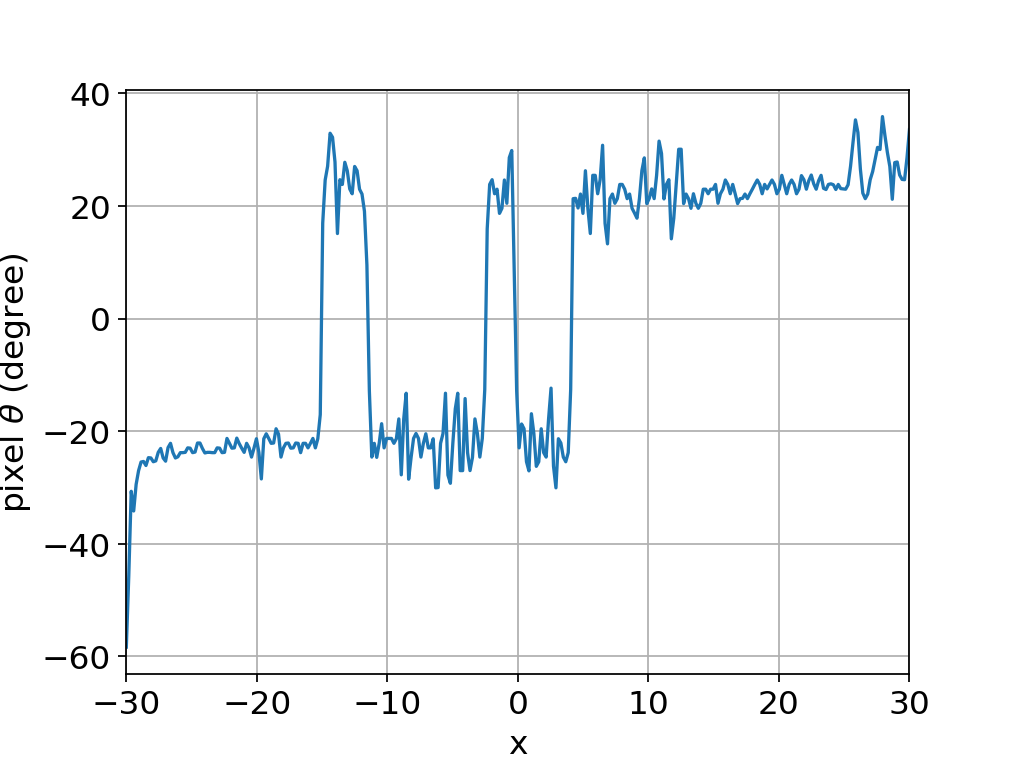

/var/folders/d4/79k8920n66j07rbcltjlhjx00000gr/T/ipykernel_40067/1076934836.py:150: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<IPython.core.display.Javascript object>


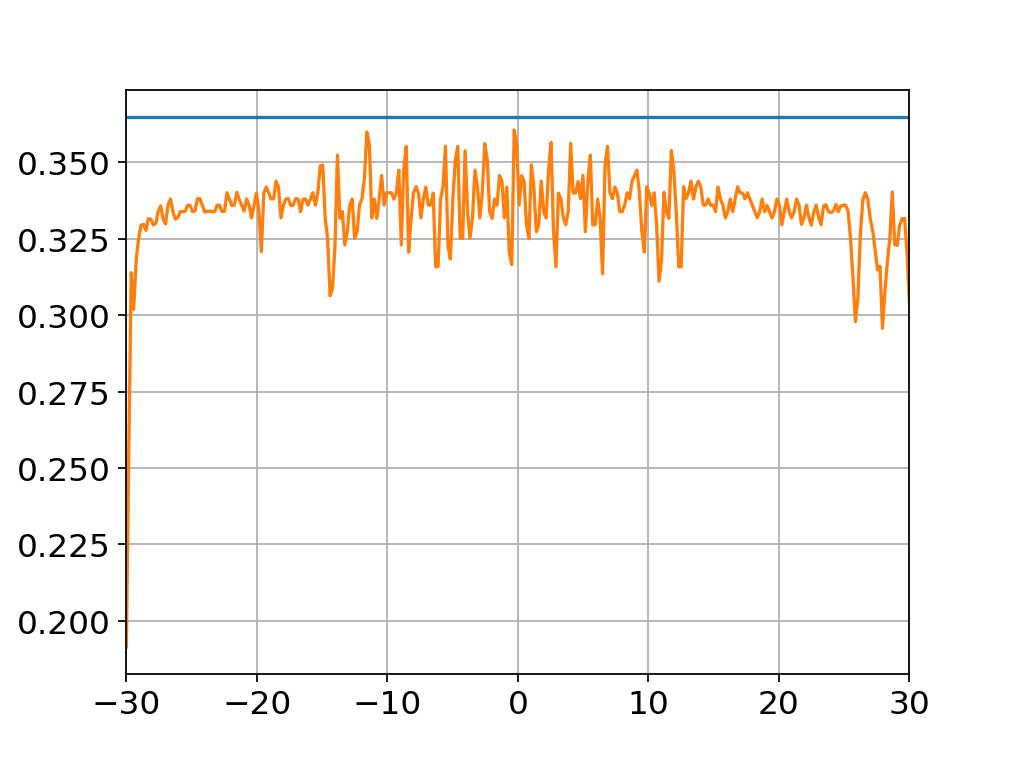

In [25]:
# Probing properties of multiple facet types
if microfacets == 1:
    from scipy.interpolate import CubicSpline
#     from scipy.interpolate import Akima1DInterpolator
#     from scipy.interpolate import PchipInterpolator
    myinterpolator = CubicSpline
    itime = -1
    print('Probing itime =',itime)
    print('Probing time =',tkeep_1Darr[itime].to('millisecond'))
    Ntot_pr = Ntotkeep_1D[itime,:]
    NQLL_pr = NQLLkeep_1D[itime,:]
    xleft = -L.magnitude
    xright = L.magnitude

    # Seeing how to smooth out point with large second derivative
#     def smoothout(x_QLC,Ntot_pr,deltax,d2Ntot_dx2_threshold):
#         dNtot_dx = np.gradient(Ntot_pr,deltax)#; print(dNtot_dx.units)
#         d2Ntot_dx2 = np.gradient(dNtot_dx,deltax)#; print(d2Ntot_dx2.units)
#         ismoothlist = np.argwhere(d2Ntot_dx2<-d2Ntot_dx2_threshold)
#         ismoothlist = np.squeeze(ismoothlist)#; print(ismoothlist)
#         Ntot_pr_smoothed = np.copy(Ntot_pr)
#         nbefore = 2; #print(nbefore)
#         nafter = nbefore+1; #print(nafter)
        
#         for ismooth in ismoothlist:
#             if ismooth < nbefore:
#                 print("Can't smooth at the beginning of the Ntot array")
#             elif ismooth > len(x_QLC)-nafter:
#                 print("Can't smooth at the end of the Ntot array")
#             else:
#                 x = x_QLC[ismooth-nbefore:ismooth+nafter].magnitude; #print("here is x", x)
#                 x = np.delete(x,nbefore); #print("here is x", x)
#                 y = Ntot_pr[ismooth-nbefore:ismooth+nafter]; #print("here is y",y)
#                 y = np.delete(y,nbefore); #print("here is y", y)
#                 spl = myinterpolator(x,y)
#                 ynew = spl(x[nbefore]) # same as spl(x_QLC[ismooth])
#                 #print('Replacing ',Ntot_pr[ismooth],'with', ynew)
#                 Ntot_pr_smoothed[ismooth] = ynew
#         return d2Ntot_dx2, Ntot_pr_smoothed

#     d2Ntot_dx2_threshold = AssignQuantity(10000,d2Ntot_dx2.units)
#     d2Ntot_dx2, Ntot_pr_smoothed = smoothout(x_QLC,Ntot_pr,deltax,d2Ntot_dx2_threshold)
#     plt.figure()
#     plt.plot(x_QLC,d2Ntot_dx2.magnitude/1e3)
#     plt.grid(True)
#     plt.ylabel(r'$d^2N_{tot}/dx^2$')
#     plt.xlim([xleft,xright])
#     plt.figure()
#     plt.plot(x_QLC,Ntot_pr,'-+',label='orig')
#     plt.plot(x_QLC,Ntot_pr_smoothed,label='smoothed')
#     plt.ylabel(r'$N_{tot}$')
#     plt.legend()
#     plt.xlim([xleft,xright])
#     Ntot_pr = np.copy(Ntot_pr_smoothed)
    
#     # Again
#     d2Ntot_dx2_threshold = AssignQuantity(50,d2Ntot_dx2.units)
#     d2Ntot_dx2, Ntot_pr_smoothed = smoothout(x_QLC,Ntot_pr,deltax,d2Ntot_dx2_threshold)
#     plt.figure()
#     plt.plot(x_QLC,d2Ntot_dx2.magnitude/1e3)
#     plt.grid(True)
#     plt.ylabel(r'$d^2N_{tot}/dx^2$')
#     plt.xlim([xleft,xright])
#     plt.figure()
#     plt.plot(x_QLC,Ntot_pr,'-+',label='orig')
#     plt.plot(x_QLC,Ntot_pr_smoothed,label='smoothed')
#     plt.ylabel(r'$N_{tot}$')
#     plt.legend()
#     plt.xlim([xleft,xright])
#     Ntot_pr = np.copy(Ntot_pr_smoothed)
    

    # Specifying how to partition among the three facets
    beta_trans = np.sin(theta/2)/np.cos(theta/2)
    print('beta_trans =', beta_trans)
    delta_beta = beta_trans/beta_trans_factor
    print('delta_beta',delta_beta)

    # Now we'll work with the Ntot data of interest
    h_py = h_pr*h_pyfactor
    Ntot_pyneg = 1/h_py * (np.cos(theta)*h_pr* Ntot_pr -np.sin(theta)*x_QLC)
    Ntot_pypos = 1/h_py * (np.cos(theta)*h_pr* Ntot_pr +np.sin(theta)*x_QLC)

    plt.figure()
    plt.plot(x_QLC,Ntot_pr,label='prismatic')
    # plt.plot(x_QLC,Ntot_pyneg,label='negative-sloped '+str(theta))
    # plt.plot(x_QLC,Ntot_pypos,label='positive-sloped '+str(theta))
    plt.xlabel('x',fontsize=fontsize)
    plt.ylabel('Ntot',fontsize=fontsize)
    plt.grid(True)
    plt.legend()
    plt.xlim([xleft,xright])

    z_pr = h_pr * Ntot_pr
    dx = x_QLC[1]-x_QLC[0]
    beta = np.gradient(z_pr,dx)
    beta.ito('dimensionless')
    alpha_pyneg = QLC.get_alpha(beta.magnitude,-beta_trans.magnitude,delta_beta.magnitude)
    alpha_pypos = 1-QLC.get_alpha(beta.magnitude, beta_trans.magnitude,delta_beta.magnitude)
    alpha_pr = 1 - alpha_pyneg - alpha_pypos

    plt.figure()
    plt.plot(x_QLC,alpha_pr,label='prismatic')
    plt.plot(x_QLC,alpha_pyneg,label='negative-sloped '+str(theta.to('degree')))
    plt.plot(x_QLC,alpha_pypos,label='positive-sloped '+str(theta.to('degree')))
    plt.xlabel('x',fontsize=fontsize)
    plt.ylabel(r'$\alpha$',fontsize=fontsize)
    plt.legend()
    plt.grid(True)
    plt.xlim([xleft,xright])

    Nstar_pr = Nstar
    Nstar_py = Nstar_pr*Nstarfactor; print(Nstar_py)
    NQLL_eq_pr    = Nbar - Nstar_pr*np.sin(2*np.pi*Ntot_pr)
    NQLL_eq_pyneg = Nbar - Nstar_py*np.sin(2*np.pi*Ntot_pyneg)
    NQLL_eq_pypos = Nbar - Nstar_py*np.sin(2*np.pi*Ntot_pypos)
    NQLL_eq = alpha_pr*NQLL_eq_pr + alpha_pyneg*NQLL_eq_pyneg + alpha_pypos*NQLL_eq_pypos

    plt.figure()
    plt.plot(x_QLC,NQLL_eq_pr,label='prismatic')
    # plt.plot(x_QLC,NQLL_eq_pyneg,label='negative-sloped '+str(theta))
    # plt.plot(x_QLC,NQLL_eq_pypos,label='positive-sloped '+str(theta))
    plt.plot(x_QLC,NQLL_eq,label='combined')
    plt.xlabel('x',fontsize=fontsize)
    plt.ylabel('NQLL(eq)',fontsize=fontsize)
    plt.legend()
    plt.grid(True)
    plt.xlim([xleft,xright])

    # slopes = dx.magnitude*np.ones(len(x_QLC)) + 1j*beta.magnitude*dx.magnitude
    slopes = np.ones(len(x_QLC)) + 1j*beta.magnitude
    angles = AssignQuantity(np.angle(slopes),'radian')
    angles.ito('degree')

    plt.figure()
    if (np.max(np.abs(angles.magnitude)) > 0.1):
        plt.plot(x_QLC,angles.magnitude)
        plt.xlabel('x',fontsize=fontsize)
        plt.ylabel(r'pixel $\theta$ ('+str(angles.units)+')',fontsize=fontsize)
    else:
        plt.plot(x_QLC,angles.magnitude*500)
        plt.xlabel('x',fontsize=fontsize)
        plt.ylabel(r'pixel $\theta$ ('+str(angles.units)+'*1000)',fontsize=fontsize)

    plt.grid(True)
    plt.xlim([xleft,xright])
    
    # The corrected diffusion coefficient
    Doverdeltay2 = Doverdeltax2*np.cos(angles)
    plt.figure()
    plt.plot(x_QLC,Doverdeltax2.magnitude*np.ones(len(x_QLC))*deltax**2*1e3,label='D x 1000')
    plt.plot(x_QLC,Doverdeltay2.magnitude*deltax**2*1e3,label='corrected')
    plt.grid(True)
    plt.xlim([xleft,xright])


In [26]:
# def smoothout(x_QLC,Ntot_pr,deltax,d2Ntot_dx2_threshold):
#         dNtot_dx = np.gradient(Ntot_pr,deltax)#; print(dNtot_dx.units)
#         d2Ntot_dx2 = np.gradient(dNtot_dx,deltax)#; print(d2Ntot_dx2.units)
#         ismoothlist = np.argwhere(d2Ntot_dx2<-d2Ntot_dx2_threshold)
#         ismoothlist = np.squeeze(ismoothlist)#; print(ismoothlist)
# #         ismoothlist = [317]
#         Ntot_pr_smoothed = np.copy(Ntot_pr)
#         nbefore = 2; #print(nbefore)
#         nafter = nbefore+1; #print(nafter)
        
#         for ismooth in ismoothlist:
#             if ismooth < nbefore:
#                 print("Can't smooth at the beginning of the Ntot array")
#             elif ismooth > len(x_QLC)-nafter:
#                 print("Can't smooth at the end of the Ntot array")
#             else:
#                 x = x_QLC[ismooth-nbefore:ismooth+nafter]#; print("here is x", x)
#                 y = Ntot_pr[ismooth-nbefore:ismooth+nafter]#; print("here is y",y)
#                 spl = CubicSpline(x, y)     
#                 Ntot_pr_smoothed[ismooth] = spl(x_QLC[ismooth])
#         return d2Ntot_dx2, Ntot_pr_smoothed

# d2Ntot_dx2_threshold = AssignQuantity(10000,d2Ntot_dx2.units)
# d2Ntot_dx2, Ntot_pr_smoothed = smoothout(x_QLC.magnitude,Ntot_pr,deltax,d2Ntot_dx2_threshold)

# # print(len(x_QLC))
# # print(len(x_QLC)-nbefore)
# # ismooth = 317
# # x = x_QLC[ismooth-nbefore:ismooth+nafter+1]
# # y = x_QLC[ismooth-nbefore:ismooth+nafter+1]

In [27]:
# # This is just to get a visual on the partitioning among the three facets (alpha)
# beta = np.linspace(-beta_trans*2,beta_trans*2,500)
# delta_beta = beta_trans/5
# alpha_pyneg = QLC.get_alpha(beta,-beta_trans,delta_beta)
# alpha_pypos = 1-QLC.get_alpha(beta, beta_trans,delta_beta)
# alpha_pr = 1 - alpha_pyneg - alpha_pypos
# plt.figure()
# plt.plot(beta,alpha_pr,label='prismatic')
# plt.plot(beta,alpha_pyneg,label='negative-sloped '+str(theta))
# plt.plot(beta,alpha_pypos,label='positive-sloped '+str(theta))
# plt.xlabel(r'$\beta$')
# plt.ylabel(r'$\alpha$')
# plt.grid(True)
# plt.legend()

In [28]:
# plt.figure()
# plt.plot(x_QLC,NQLL_eq-NQLL_eq_pr,label='combined-'+str(theta))
# plt.xlabel('x')
# plt.ylabel('NQLL(eq)')
# plt.legend()
# plt.grid(True)
# plt.xlim([xleft,xright])

In [29]:
# m_actual = (NQLL_pr-(Nbar-Nstar))/(2*Nstar)
# sigma_m_actual = sigmaI_QLC - m_actual * sigma0
# Nstar_est = alpha_pr*Nstar_pr + alpha_pyneg*Nstar_py + alpha_pypos*Nstar_py
# m_predicted = (NQLL_pr -(Nbar-Nstar_est))/(2*Nstar_est)
# sigma_m_predicted = sigmaI_QLC - m_predicted * sigma0

# plt.figure()
# plt.plot(x_QLC,sigma_m_actual*100,label='actual')
# plt.plot(x_QLC,sigma_m_predicted*100,label='predicted')
# plt.xlabel('x')
# plt.ylabel(r'$\sigma_m$ (%)')
# plt.grid(True)
# plt.legend()
# plt.xlim([xleft,xright])

In [30]:
# This is testing how to take a 1st derivative using FT

# Z_pr = rfft(z_pr.magnitude)
# j_list = np.array([j for j in range(len(Z_pr))])
# dZpr_dx = 1j*Z_pr*j_list
# dzpr_dx = np.real(irfft(dZpr_dx))*np.pi/L.magnitude

# dx = x_QLC[1]-x_QLC[0]
# dzpr_dx_diff = np.diff(z_pr)/dx
# plt.figure()
# plt.plot(x_QLC,dzpr_dx,label='FT')
# # plt.plot(x_QLC[1:],dzpr_dx_diff,label='diff')
# plt.plot(x_QLC,beta,label='gradient')
# plt.grid(True)
# plt.legend()

In [31]:
# # This is testing how to take a 1st derivative using FT

# xmax = 2
# npts = 500
# x_long = np.linspace(-xmax,xmax,npts+1)
# x = x_long[0:-1]
# x = (x_long[1:]+x_long[0:-1])/2
# print(len(x))
# dx = x[1]-x[0]; print(dx)
# dummy = np.cos(x*2*np.pi/.5)
# plt.figure()
# plt.plot(x,dummy)

# Dummy = np.real(rfft(dummy))
# j_list = np.array([j for j in range(len(Dummy))])
# scalefactor = np.pi/xmax
# dDummy_dx = 1j*Dummy*j_list
# ddummy_dx = np.real(irfft(dDummy_dx)) * scalefactor

# ddummy_dx_diff = np.diff(dummy) / dx
# plt.figure()
# plt.plot(x,ddummy_dx,label='FT')
# plt.plot(x[1:],ddummy_dx_diff,label='diff')
# plt.legend()

# testfactor = np.median(ddummy_dx[1:]/ddummy_dx_diff)
# print(testfactor)

In [32]:
# Here, trying to symmetrize x_QLC with correct boundary conditions

# print(nx_crystal)
# x_QLC_long = np.linspace(-L,L,nx_crystal+1)
# print(len(x_QLC_long))
# print(x_QLC_long[-1])

# x_QLC = x_QLC_long[0:-1]
# print(len(x_QLC))
# print(x_QLC[-1])

In [33]:
# parameterlist_mag = []

# # The following notes are based on np.gradient for calculating beta

# # 1. Baseline
# # parameterlist_mag.append(
# #     [L.magnitude, D.magnitude, nu_kin.magnitude, 
# #      sigmaI_corner, c_r_percent.magnitude, tau_eq.magnitude])
# # Results: ... 

# # 2. Higher nu_kin and bigger tau
# # parameterlist_mag.append(
# #     [L.magnitude, D.magnitude, 140, 
# #      sigmaI_corner, c_r_percent.magnitude, 5])
# # Results: Nice microfaceting at intervals of 5-10 micrometers. However, there are two spikes that I don't like
# # at 10,000 ms

# # 2-1. Like #2, but with a lower sigmaI_corner
# # parameterlist_mag.append(
# #     [L.magnitude, D.magnitude, 140, 
# #      0.213, c_r_percent.magnitude, 5])
# # Results: Nice microfaceting at intervals of 5-10 micrometers. However, there are several spikes that I don't like.

# # 2-2. Like #2, but with a higher sigmaI_corner
# parameterlist_mag.append(
#     [L.magnitude, D.magnitude, 140, 
#      0.26, c_r_percent.magnitude, 5])
# # Results: I was hoping this will remove the spikes. Twice submitted, the kernel dies at 12,000 ms. 
# # So submitting it for 10,000 ms, but there's still a spike.







# # 2-2. Like #2, but with a pyramidal facet that is more volatile than the prismatic
# # sigma0factor = 0.9; print('sigma0factor',sigma0factor)
# # parameterlist_mag.append(
# #     [L.magnitude, D.magnitude, 140, 
# #      sigmaI_corner, c_r_percent.magnitude, 5])
# # Results: ...

# # 2-3. Higher nu_kin and bigger tau
# # parameterlist_mag.append(
# #     [L.magnitude, D.magnitude, 140, 
# #      sigmaI_corner, c_r_percent.magnitude, 5])
# # Results: ...



# print(parameterlist_mag)